In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [2]:
import os
import zipfile

In [1]:
mask_dir = os.path.join('dataset')

model_dir = os.path.join('mask_detector.model')

plot_dir = os.path.join('plot.png')

NameError: name 'os' is not defined

In [69]:
mask_names = os.listdir(mask_dir)
print(mask_names)


['without_mask', 'with_mask']


In [71]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(mask_dir[:]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [77]:
print(len(data))
print(len(labels))
print(labels[:10])

1376
1376
['without_mask' 'without_mask' 'without_mask' 'without_mask'
 'without_mask' 'without_mask' 'without_mask' 'without_mask'
 'without_mask' 'without_mask']


In [78]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [79]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [80]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [82]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
basemodel = MobileNetV2(weights = "imagenet", include_top = False,
                       input_tensor = Input(shape=(224,224,3)))

C:\Users\Muhammad Salman\.conda\envs\tensorflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 14s 2us/step


In [83]:
# construct the head of the model that will be placed on top of the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation = "softmax")(headmodel)

In [84]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=basemodel.input, outputs=headmodel)

In [86]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in basemodel.layers:
    layer.trainale = False

In [87]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [89]:
# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=5)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 34 steps, validate on 276 samples
Epoch 1/5
34/34 [==============================] - 340s 10s/step - loss: 0.0172 - accuracy: 0.9934 - val_loss: 0.0273 - val_accuracy: 0.9922
Epoch 2/5
34/34 [==============================] - 339s 10s/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.0216 - val_accuracy: 0.9922
Epoch 3/5
34/34 [==============================] - 338s 10s/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 0.0247 - val_accuracy: 0.9922
Epoch 4/5
34/34 [==============================] - 360s 11s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9922
Epoch 5/5
34/34 [==============================] - 354s 10s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9922


In [90]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

In [91]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [92]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [98]:
# serialize the model to disk
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

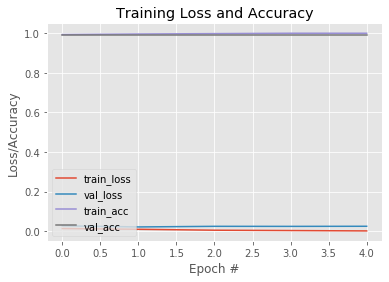

In [107]:
# plot the training loss and accuracy
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")